In [160]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from scipy.stats import anderson, kstest, shapiro

In [52]:
file = "data/sleep_merged.csv"

In [53]:
data = pd.read_csv(file)

In [54]:
df = copy.deepcopy(data)

In [61]:
cols = df.columns

#### Vore column encoding  

In [56]:
df["Vore_class"] = df["Vore"]
df.loc[df["Vore_class"] == "carni","Vore_class"] = 1
df.loc[df["Vore_class"] == "insecti","Vore_class"] = 2
df.loc[df["Vore_class"] == "herbi","Vore_class"] = 3
df.loc[df["Vore_class"] == "omni","Vore_class"] = 4

In [60]:
df.head(10)

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,Vore_class,Vore_herbi,Vore_insecti,Vore_omni
0,Cheetah,Acinonyx,Carnivora,lc,50.000,0.0,12.1,11.90,NaN,NaN,20.0,93.0,NaN,NaN,NaN,1,0,0,0
1,Northern fur seal,Callorhinus,Carnivora,vu,20.490,0.0,8.7,15.30,NaN,1.4,26.0,358.0,NaN,NaN,NaN,1,0,0,0
2,Lion,Panthera,Carnivora,vu,161.499,0.0,13.5,10.50,NaN,NaN,20.0,115.0,NaN,NaN,NaN,1,0,0,0
3,Tiger,Panthera,Carnivora,en,162.564,0.0,15.8,8.20,NaN,NaN,23.0,112.0,NaN,NaN,NaN,1,0,0,0
4,Caspian seal,Phoca,Carnivora,vu,86.000,0.0,3.5,20.50,NaN,0.4,35.0,334.0,NaN,NaN,NaN,1,0,0,0
5,Pilot whale,Globicephalus,Cetacea,cd,800.000,0.0,2.7,21.35,NaN,0.1,60.0,456.0,NaN,NaN,NaN,1,0,0,0
6,Common porpoise,Phocoena,Cetacea,vu,53.180,0.0,5.6,18.45,NaN,NaN,20.0,319.0,NaN,NaN,NaN,1,0,0,0
7,Bottle-nosed dolphin,Tursiops,Cetacea,NaN,173.330,0.0,5.2,18.80,NaN,NaN,60.0,365.0,NaN,NaN,NaN,1,0,0,0
8,Thick-tailed opposum,Lutreolina,Didelphimorphia,lc,0.370,0.0,19.4,4.60,NaN,6.6,NaN,NaN,NaN,NaN,NaN,1,0,0,0
9,Potoroo,Potorous,Diprotodontia,NaN,1.100,0.0,11.1,12.90,NaN,1.5,11.0,38.0,NaN,NaN,NaN,3,1,0,0


In [ ]:
df = df.drop(["Vore_insecti","Vore_herbi","Vore_omni"], axis=1)

In [58]:
df = pd.get_dummies(df, columns=["Vore"], prefix=["Vore"], drop_first=True)


In [59]:
df[["Vore_insecti","Vore_herbi","Vore_omni"]] = df[["Vore_insecti","Vore_herbi","Vore_omni"]].astype(int)


In [72]:
df["Vore"] = data["Vore"]

In [105]:
cols = df.columns

In [102]:
df.head()

,Species,Genus,Order,Conservation,BodyWt,BrainWt,TotalSleep,Awake,NonDreaming,Dreaming,LifeSpan,Gestation,Predation,Exposure,Danger,Vore_class,Vore_herbi,Vore_insecti,Vore_omni,Vore
0,Cheetah,Acinonyx,Carnivora,lc,50.000,126.92,12.1,11.9,NaN,NaN,20.0,93.0,1.0,2.0,1.0,1,0,0,0,carni
1,Northern fur seal,Callorhinus,Carnivora,vu,20.490,98.55,8.7,15.3,NaN,1.4,26.0,358.0,1.0,2.0,1.0,1,0,0,0,carni
2,Lion,Panthera,Carnivora,vu,161.499,234.11,13.5,10.5,NaN,NaN,20.0,115.0,1.0,2.0,1.0,1,0,0,0,carni
3,Tiger,Panthera,Carnivora,en,162.564,235.14,15.8,8.2,NaN,NaN,23.0,112.0,1.0,2.0,1.0,1,0,0,0,carni
4,Caspian seal,Phoca,Carnivora,vu,86.000,161.53,3.5,20.5,NaN,0.4,35.0,334.0,1.0,2.0,1.0,1,0,0,0,carni


### Correlation analysis

##### I create some useful functions to check for correlations and normality, that we will often need throughout this notebook 

In [148]:
#I define a correlation function that returns the corr a target column has with other columns if corr > t (threshold)
#I use both pearson and spearman because some features are not normally distributed etc.

def corr_func(target: str, t):
    spear_corr = {}
    pears_corr = {}
    for col in cols:
        if df[col].dtype in ["float64", "int64"] and col != target:
            # Pairwise deletion to include only rows where there is no missing values at all in either of the two features
            valid_rows = df[[col, target]].dropna()

            if len(valid_rows) > 0:  # Check if there are valid rows for correlation (since I know the dataset, it's useless here but i still include it)
                correlation, p_value = spearmanr(valid_rows[col], valid_rows[target])
                correlation2 = valid_rows[col].corr(valid_rows[target])
                if abs(correlation) >= t:
                    spear_corr[col] = round(correlation, 2)
                elif abs(correlation2) >= t:
                    pears_corr[col] = round(correlation2, 2)
    print(f"Correlation for {target} : \n\n Spearman correlation is: {spear_corr}", "\n\n", f"Pearson correlation is: {pears_corr}")

    return


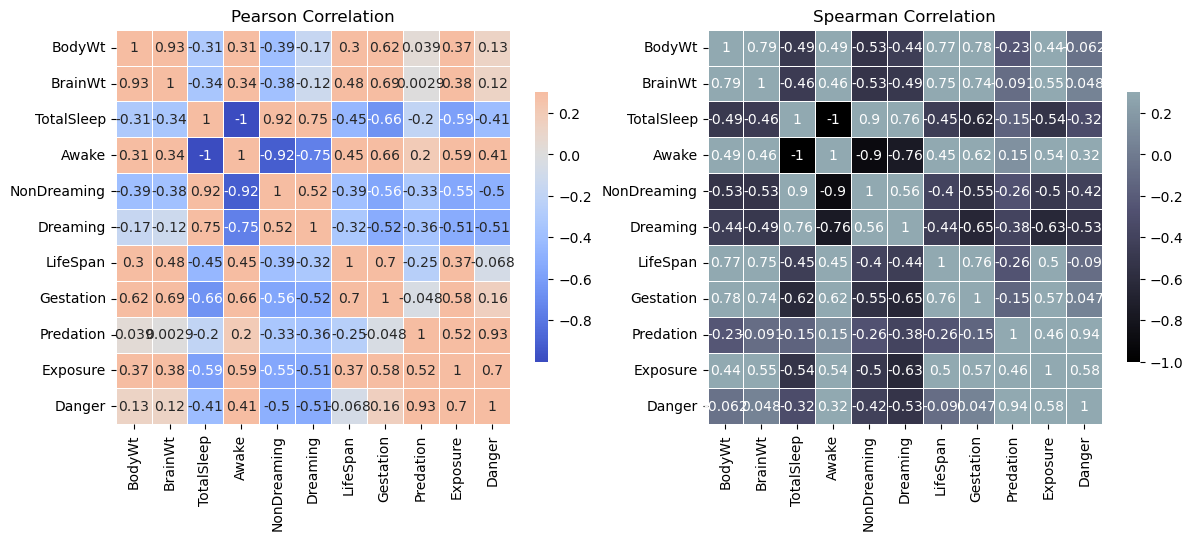

In [108]:
# Filtering only numerical columns for correlation matrix
num_df = df.select_dtypes(include=["float", "int"])
num_df = num_df.drop(["Vore_herbi","Vore_insecti","Vore_omni"], axis=1)

# Create subplots with two columns to display two heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Calculate and draw the Pearson correlation heatmap
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm',
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[0])
axes[0].set_title("Pearson Correlation")

# Calculate and draw the Spearman correlation heatmap
sns.heatmap(num_df.corr(method='spearman'), annot=True, cmap='bone',
            vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=axes[1])
axes[1].set_title("Spearman Correlation")

# Display the plot
plt.show()


##### Here we will investigate the distribution of each feature 

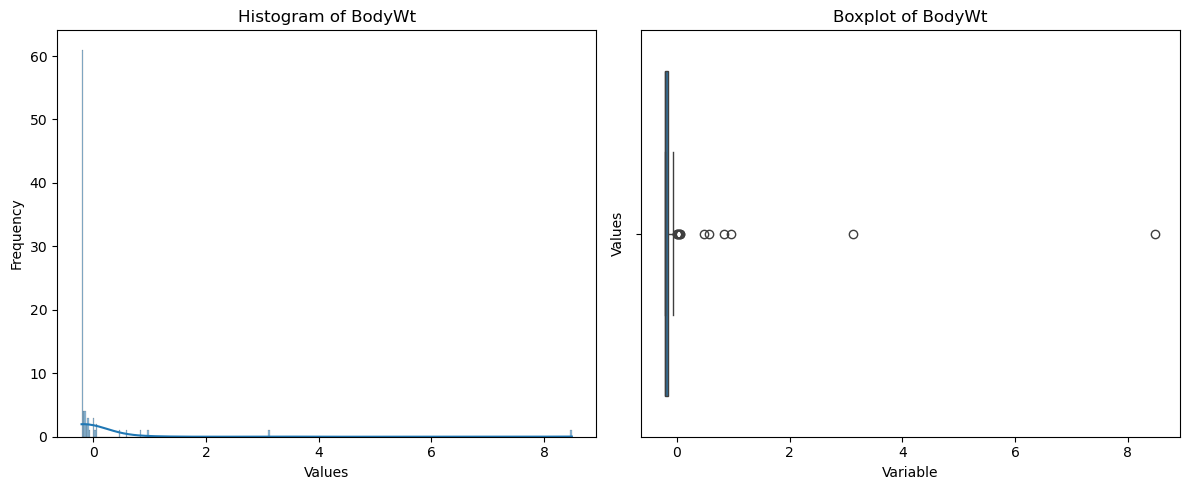

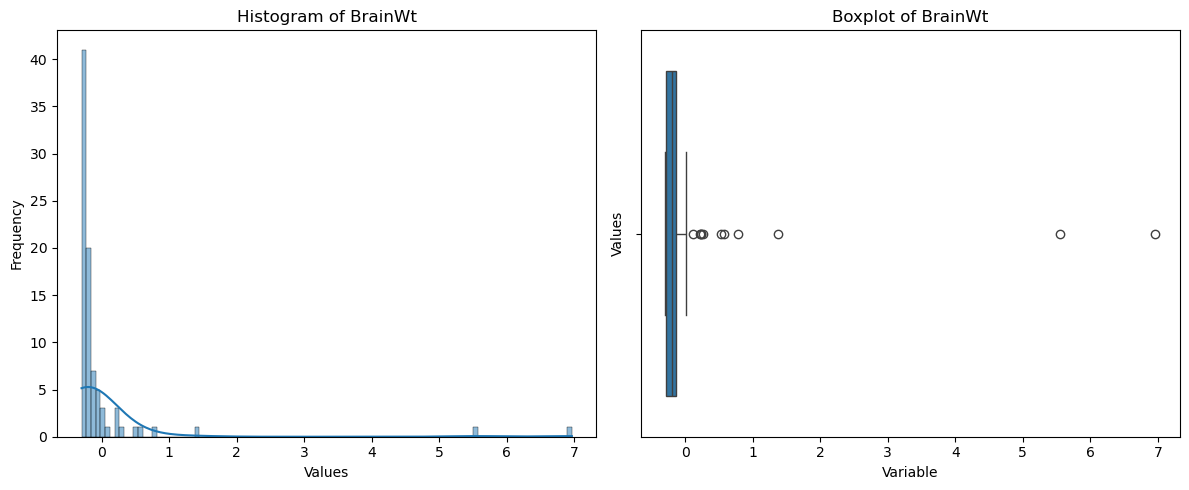

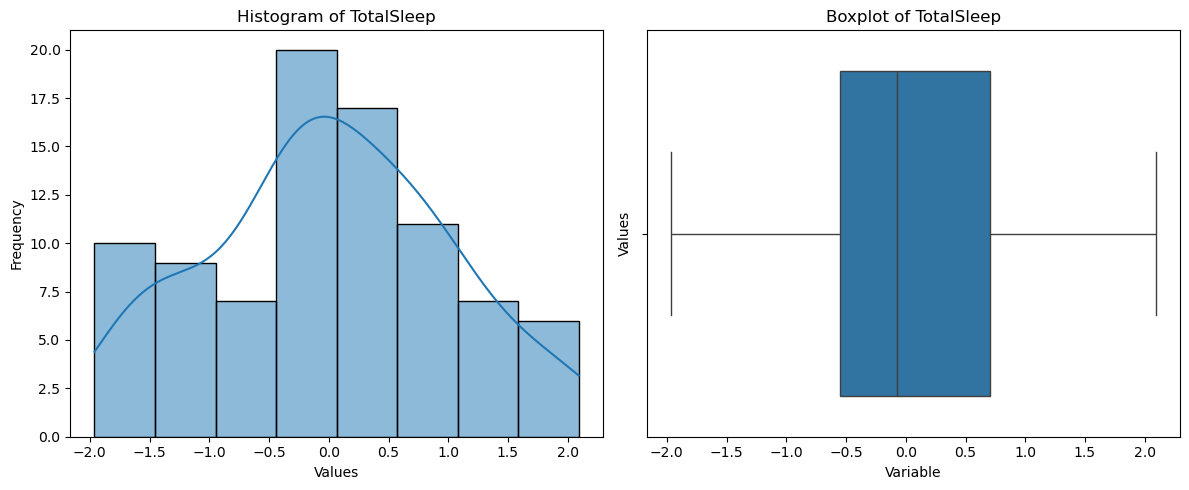

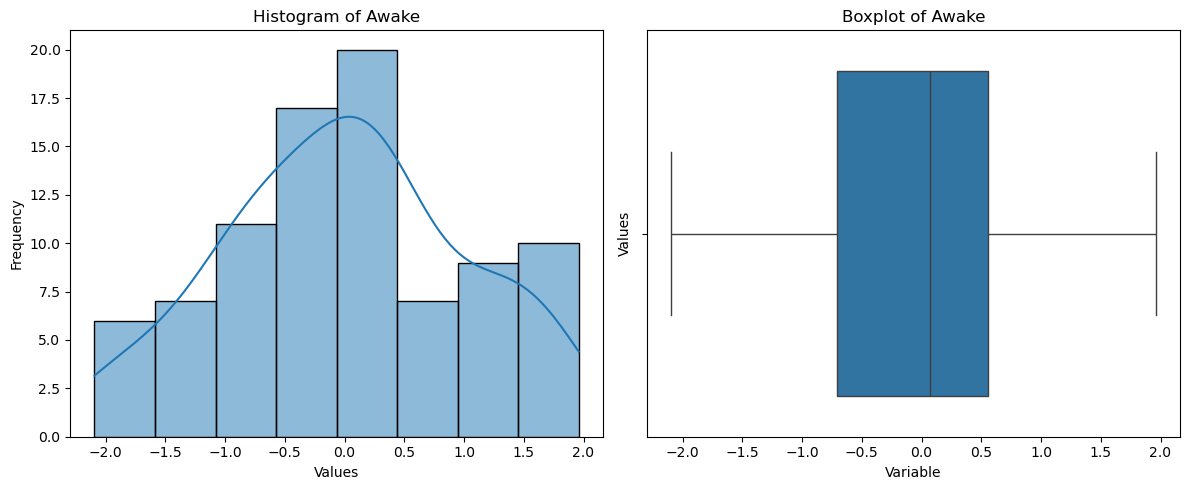

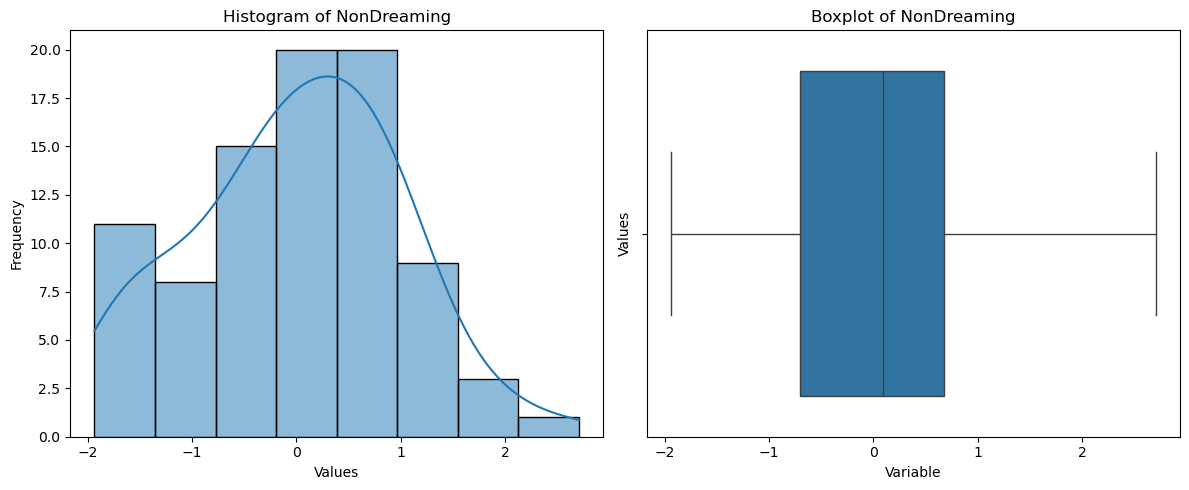

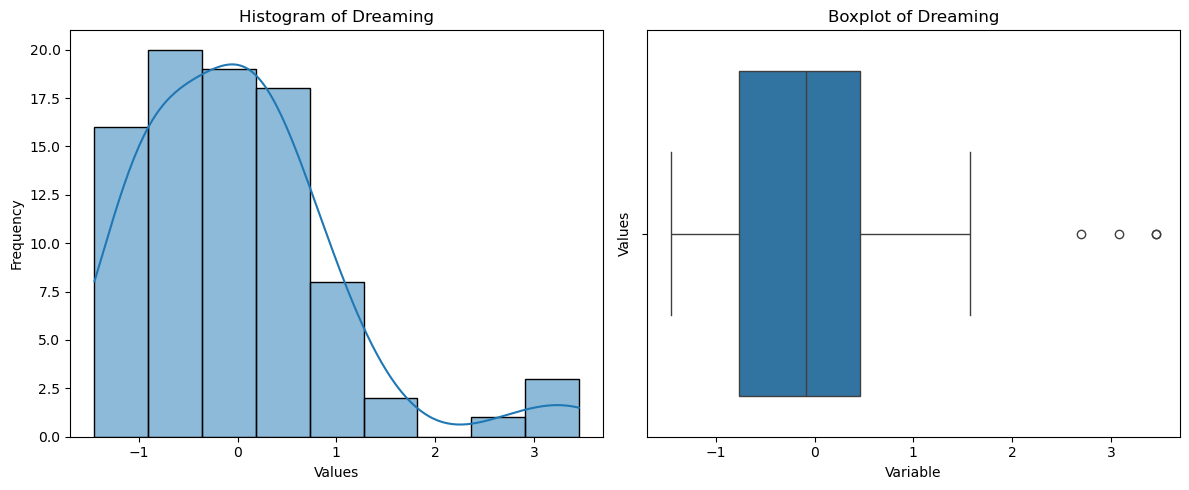

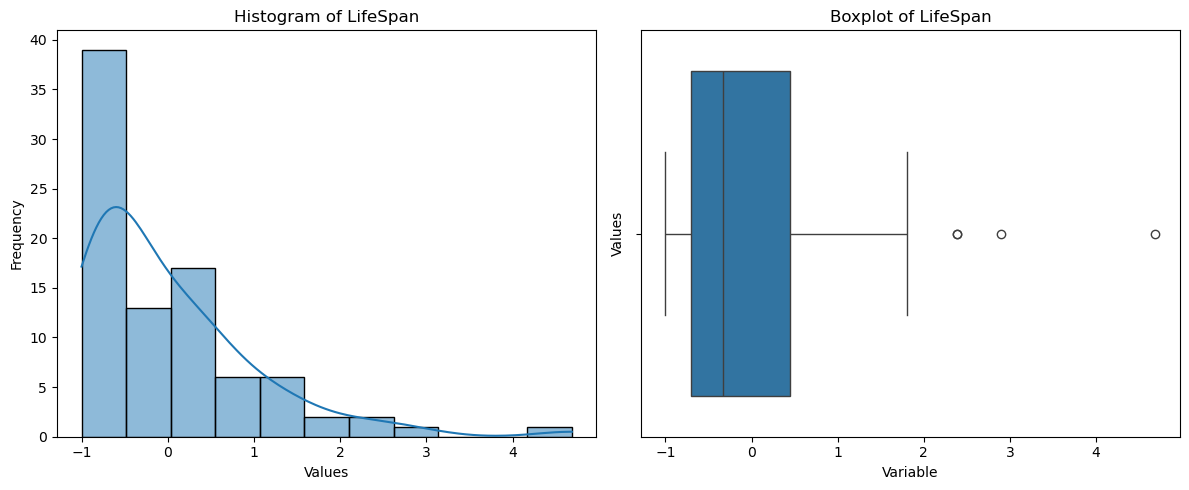

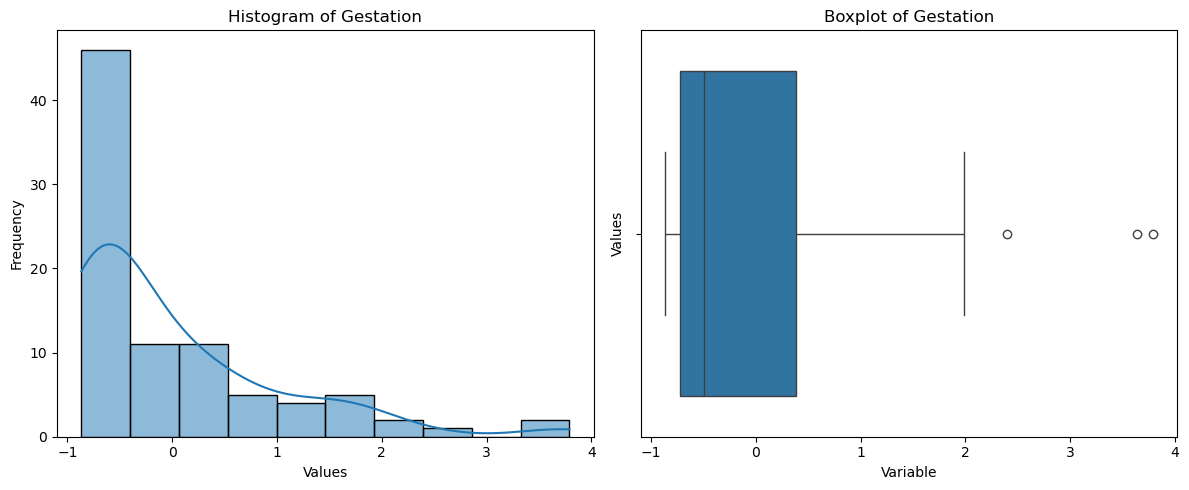

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric columns to plot
numeric_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and col not in ['Predation', 'Exposure', 'Danger']]

# Loop through the numeric columns and create separate figures for each histogram and boxplot
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with two columns

    # Plot the histogram on the left (first subplot)
    sns.histplot(data=df, x=col, bins="auto", kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram of {col}")
    axes[0].set_xlabel("Values")
    axes[0].set_ylabel("Frequency")

    # Plot the boxplot on the right (second subplot)
    sns.boxplot(data=df, x=col, ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_xlabel("Variable")
    axes[1].set_ylabel("Values")

    plt.tight_layout()
    plt.show()  


##### Here next we will define a function to test not graphically but analyticaly the normality of our features

In [110]:
from scipy.stats import kstest, anderson, norm

def normal_test(feature, alpha):
    result = {}

    # Kstest
    ks_stat, ks_pvalue = kstest(feature, 'norm')
    ks_normal = ks_pvalue > alpha
    result['Kolmogorov-Smirnov'] = {'Statistic': ks_stat, 'p_value': ks_pvalue, 'Normal': ks_normal}

    ''''#Anderson
    ad_statistic, ad_critical_values, ad_significance_level = anderson(feature, dist="norm")
    ad_normal = ad_statistic < ad_critical_values[ad_significance_level == alpha][0]'''
    ##ANDERSON TEST seems to fail unexpectedly, I try to make it work, and to not block the code if it fails


    # Check if the sample size is sufficient for Anderson-Darling
    if len(feature) >= 3:
        try:
            ad_statistic, ad_critical_values, ad_significance_level = anderson(feature, dist="norm")
            ad_normal = ad_statistic < ad_critical_values[ad_significance_level == alpha][0]
            result['Anderson-Darling'] = {'Statistic': ad_statistic, 'Critical Values': ad_critical_values, 'Significance Level': ad_significance_level, 'Normal': ad_normal}
        except (ValueError, IndexError):
            result['Anderson-Darling'] = {'Statistic': None, 'Critical Values': None, 'Significance Level': None, 'Normal': False}
            result['Error'] = 'Anderson-Darling test failed'
    else:
        result['Error'] = 'Insufficient data points for testing'


    return result

##### To assess whether a feature is normal or not, we can run some statistical test, extract their p-value and compare it to the p value cutoff. (we can set it 0.05, higher or lower).

In [111]:
label = df["TotalSleep"].dropna().astype(float)
result = normal_test(label, alpha=0.05)
print(result)

{'Kolmogorov-Smirnov': {'Statistic': 0.9850387733233962, 'p_value': 3.335620642889021e-159, 'Normal': False}, 'Anderson-Darling': {'Statistic': None, 'Critical Values': None, 'Significance Level': None, 'Normal': False}, 'Error': 'Anderson-Darling test failed'}


## Data cleaning

#### We now will fill out the missing values for Predation, Exposure, Danger

In [112]:
df["Predation"] = df["Predation"].fillna(df.groupby("Order")["Predation"].transform("mean").round())
df["Exposure"] = df["Exposure"].fillna(df.groupby("Order")["Exposure"].transform("mean").round())
df["Danger"] = df["Danger"].fillna(df.groupby("Order")["Danger"].transform("mean").round())

##### It seems grouping by vore, gives some clues on the these features as well, so we can see that there is a low std dev of pred, exp, dang, grouped by vore
Notes: Actually grouping by vore was doable at first, but it's a choice. Order and Vore are very much linked, they got the same vore for the same order (almost), sometimes herbi/omni but herbi/omni have almost the same mean. So it's fine and on parallel grouping by order can contain real information other than vore for predation exposure

In [113]:
df["Predation"] = df["Predation"].fillna(df.groupby("Vore")["Predation"].transform("mean").round())
df["Exposure"] = df["Exposure"].fillna(df.groupby("Vore")["Exposure"].transform("mean").round())
df["Danger"] = df["Danger"].fillna(df.groupby("Vore")["Danger"].transform("mean").round())

#### Here we will correct the 0 values found in the BrainWt feature that should not be 0

In [114]:
df["BrainWt"] = df["BrainWt"].replace(0, np.nan)

In [115]:
df_model = df[["BodyWt","BrainWt"]].dropna()

In [116]:
spearman_corr, p_value = spearmanr(df_model["BodyWt"],df_model["BrainWt"])
print(spearman_corr)
print(p_value)

0.793682762220538
4.845842534845403e-20


##### We train a linear regression model to fill out the 0 values fo brain weight based on body weight

In [117]:
feature = df_model["BodyWt"].values.reshape(-1,1)
target = df_model["BrainWt"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.1, random_state = 11)

In [118]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [119]:
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

15158.215911207442 0.7055609711128541


##### We do the regression imputation

In [ ]:
df_model_null = df[df["BrainWt"].isnull()]
df_model_complete = df[-df["BrainWt"].isnull()]

model = LinearRegression()

# Train the model using the complete data
X = df_model_complete["BodyWt"].values.reshape(-1, 1)
y = df_model_complete["BrainWt"].values
model.fit(X, y)

# Use the trained model to predict "BrainWt" for the missing values
X_predict = df_model_null["BodyWt"].values.reshape(-1, 1)
y_pred = model.predict(X_predict)
y_pred = np.maximum(y_pred, 0)

#rounding
y_pred = np.round(y_pred,2)
# Replace the missing "BrainWt" values with the predicted values
df.loc[df["BrainWt"].isnull(), "BrainWt"] = y_pred

#### Dealing with remaining NA in Gestation using brainwt, bodywt, totalsleep

##### We going to fill some LifeSpan rows where gestation is available using regression imputation again

In [150]:
corr_func("LifeSpan",0)

Correlation for LifeSpan : 

 Spearman correlation is: {'BodyWt': 0.76, 'BrainWt': 0.74, 'TotalSleep': -0.45, 'Awake': 0.45, 'NonDreaming': -0.4, 'Dreaming': -0.42, 'Gestation': 0.76, 'Predation': -0.26, 'Exposure': 0.5, 'Danger': -0.08} 

 Pearson correlation is: {}


In [124]:
# We going to fill some LifeSpan rows where gestation is available
df_model = df.dropna()
df_model_features = df_model[["BrainWt", "TotalSleep","Gestation"]]
df_model_target = df_model[["LifeSpan"]]

X_train, X_test, y_train, y_test = train_test_split(df_model_features, df_model_target, test_size = 0.1, random_state = 11)
y_train = y_train.values.reshape(-1,1)
model = LinearRegression()
model.fit(X_train, y_train)

df_model_features_test = df[df["LifeSpan"].isnull() & -df["Gestation"].isnull()]
X_test = df_model_features_test[["BrainWt","TotalSleep","Gestation"]]

y_pred = model.predict(X_test)
df.loc[df["LifeSpan"].isnull() & -df["Gestation"].isnull(), "LifeSpan"] = y_pred
df["LifeSpan"] = np.round(df["LifeSpan"],1)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by LinearRegression.

#### We going to FULLY fill out Gestation missing values through regression imputation

In [95]:
corr_func("Gestation",0.5)

Correlation for Gestation : 

 Spearman correlation is: {'BodyWt': 0.78, 'BrainWt': 0.74, 'TotalSleep': -0.62, 'Awake': 0.62, 'NonDreaming': -0.55, 'Dreaming': -0.65, 'LifeSpan': 0.76, 'Exposure': 0.57} 

 Pearson correlation is: {}


In [125]:
# We going to FULLY fill out Gestation missing values through regression imputation
df_model = df.dropna()
df_model_features = df_model[["BodyWt","BrainWt", "TotalSleep"]]
df_model_target = df_model[["Gestation"]]

X_train, X_test, y_train, y_test = train_test_split(df_model_features, df_model_target, test_size = 0.1, random_state = 11)
y_train = y_train.values.reshape(-1,1)
model = LinearRegression()
model.fit(X_train, y_train)

df_model_features_test = df[df["Gestation"].isnull()]
X_test = df_model_features_test[["BodyWt","BrainWt", "TotalSleep"]]

y_pred = model.predict(X_test)
gestation_minimum = df["Gestation"].min()
y_pred = np.round(np.maximum(y_pred, gestation_minimum),1)
df.loc[df["Gestation"].isnull(), "Gestation"] = y_pred
df["Gestation"] = np.round(df["Gestation"],1)

#### We going to fill the remaining LifeSpan rows now that all gestation is available

In [126]:
# We going to fill the remaining LifeSpan rows now that all gestation is available
df_model = df.dropna()
df_model_features = df_model[["BrainWt", "TotalSleep","Gestation"]]
df_model_target = df_model[["LifeSpan"]]

X_train, X_test, y_train, y_test = train_test_split(df_model_features, df_model_target, test_size = 0.1, random_state = 11)
y_train = y_train.values.reshape(-1,1)
model = LinearRegression()
model.fit(X_train, y_train)

df_model_features_test = df[df["LifeSpan"].isnull() & -df["Gestation"].isnull()]
X_test = df_model_features_test[["BrainWt","TotalSleep","Gestation"]]

y_pred = model.predict(X_test)
df.loc[df["LifeSpan"].isnull() & -df["Gestation"].isnull(), "LifeSpan"] = y_pred
df["LifeSpan"] = np.round(df["LifeSpan"],1)

#### Now we will clean Dreaming and NonDreaming

##### We begin with Dreaming, it has the least amount of missing values of the two

In [127]:
# we quickly test what Dreming correlates with

corr_func("Dreaming", 0.5)

Correlation for Dreaming : 

 Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 

 Pearson correlation is: {}


##### Correlation for Dreaming : 
 ##### Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 
 ##### So we will consider TotalSleep, Gestation and Danger

In [128]:
corr_func("Dreaming", 0.5)

Correlation for Dreaming : 

 Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 

 Pearson correlation is: {}


In [129]:
df.isna().sum()

Species          0
Genus            0
Order            0
Conservation    29
BodyWt           0
BrainWt          0
TotalSleep       0
Awake            0
NonDreaming     40
Dreaming        24
LifeSpan         0
Gestation        0
Predation        0
Exposure         0
Danger           0
Vore_class       0
Vore_herbi       0
Vore_insecti     0
Vore_omni        0
Vore             0
dtype: int64

In [140]:
df_model = df[-df["Dreaming"].isnull()]
df_model_null_dreaming = df[df["Dreaming"].isnull()]


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select the features and target
features = df_model[["TotalSleep","Exposure"]]
target = df_model[["Dreaming"]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=2)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse =", mse, "r2 =", r2)


mse = 0.4954809065909126 r2 = 0.7196643012592425


In [153]:
# trying to find the heaviest predictor from the features above

# Assuming you have already trained your linear regression model as shown in your code
# model = LinearRegression()
# model.fit(X_train, y_train)

# Access the coefficients (weights) of the features
coefficients = model.coef_

# Create a dictionary to associate feature names with their coefficients
feature_coefficients = dict(zip(features.columns, coefficients[0]))

# Find the heaviest predictor (feature with the largest absolute coefficient)
heaviest_predictor = max(feature_coefficients, key=lambda k: abs(feature_coefficients[k]))

# Print the coefficients of all features and the heaviest predictor
print("Feature Coefficients:")
for feature, coefficient in feature_coefficients.items():
    print(f"{feature}: {coefficient:.4f}")

print("\nThe Heaviest Predictor is:", heaviest_predictor)


Feature Coefficients:
TotalSleep: 0.8336
Exposure: -0.0009

The Heaviest Predictor is: TotalSleep


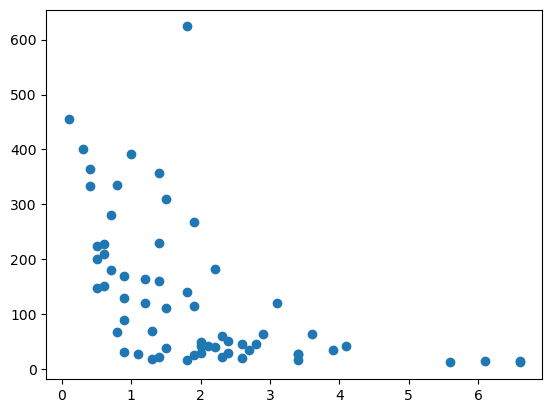

In [136]:
plt.scatter(df["Dreaming"], df["Gestation"])

In [142]:
corr_func("Dreaming",0.5)
kendal_corr = df["Dreaming"].corr(df["Gestation"], method="kendall")
print("\n\n Kendall correlation coefficient is ", kendal_corr)

Correlation for Dreaming : 

 Spearman correlation is: {'TotalSleep': 0.76, 'Awake': -0.76, 'NonDreaming': 0.56, 'Gestation': -0.69, 'Exposure': -0.63, 'Danger': -0.53} 

 Pearson correlation is: {}


 Kendall correlation coefficient is  -0.5033927081768647


##### I don't understand why but the model doesn't put any weight on Gestation despite the good negative correlation between both ? So we remove gestation in the model since it has no influence. We can dig further to understand it maybe comparing with xlstat , minitab or other...

##### We tested a bunch of models and features to assess which is preferable for imputing values in Dreaming. It seems Linear regression offers the best score as far as the test was conducted. We trained it previoudly, now we use it to do the imputation.

In [143]:
df_dreaming_null = df[df['Dreaming'].isnull()]

X_test = df_dreaming_null[["TotalSleep","Exposure"]]


# Make predictions on the test set
y_imputation = model.predict(X_test)


df.loc[df["Dreaming"].isnull(),"Dreaming"] = y_imputation


In [144]:
df["Dreaming"].isna().sum()

0

##### Dreaming now has no missing values, imputation done

#### NonDreaming cleaning

In [151]:
corr_func("NonDreaming",0.000001)

Correlation for NonDreaming : 

 Spearman correlation is: {'BodyWt': -0.53, 'BrainWt': -0.53, 'TotalSleep': 0.9, 'Awake': -0.9, 'Dreaming': 0.55, 'LifeSpan': -0.4, 'Gestation': -0.56, 'Predation': -0.26, 'Exposure': -0.5, 'Danger': -0.42} 

 Pearson correlation is: {}


In [155]:
df_ndreaming_null = df[df["NonDreaming"].isnull()]
df_ndreaming_complete = df[-df["NonDreaming"].isnull()]

feature = df_ndreaming_complete[["TotalSleep","BrainWt","BodyWt","Dreaming","Gestation"]]
target = df_ndreaming_complete[["NonDreaming"]]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=3)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("mse =", mse, "r2 =", r2)



mse = 0.3742039997939509 r2 = 0.9659470920843806


##### We get a very high R2 = 0.96 for seed n =3 which is good, it must be checked nevertheless (especially overfitting case since we used quite a lot regression imputation)

In [156]:
# Now we will to the regression imputation

x = df_ndreaming_null[["TotalSleep","BrainWt","BodyWt","Dreaming","Gestation"]]

y_imputation = model.predict(x)

df.loc[df["NonDreaming"].isnull(),"NonDreaming"] = y_imputation

In [157]:
df["NonDreaming"].isna().sum()

0

In [158]:
df["Dreaming"] = df["Dreaming"].round(2)
df["NonDreaming"] = df["NonDreaming"].round(2)

In [159]:
df.isna().sum()

Species          0
Genus            0
Order            0
Conservation    29
BodyWt           0
BrainWt          0
TotalSleep       0
Awake            0
NonDreaming      0
Dreaming         0
LifeSpan         0
Gestation        0
Predation        0
Exposure         0
Danger           0
Vore_class       0
Vore_herbi       0
Vore_insecti     0
Vore_omni        0
Vore             0
dtype: int64

##### The dataset is entirely clean except for conversation which we must fill out ourselves from sources.

### Data normalization - scaling - standardization

In [161]:
# I will standardize rather than normalize
col_std = ['BodyWt', 'BrainWt', 'TotalSleep', 'Awake', 'NonDreaming', 'Dreaming', 'LifeSpan', 'Gestation']

scaler = StandardScaler()

for col in col_std:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

##### # DF should contains only standardize data now, we will check.

In [164]:
scaled = {}
for col in col_std:
    mean = df[col].mean()
    std = df[col].std()
    scaled[col] = [mean,std]


In [165]:
scaled

{'BodyWt': [-2.0417894705750005e-17, 1.0057971500142282],
 'BrainWt': [1.0208947352875003e-17, 1.0057971500142284],
 'TotalSleep': [-8.932828933765628e-17, 1.0057971500142284],
 'Awake': [2.628803943365313e-16, 1.0057971500142284],
 'NonDreaming': [-5.563876307316876e-16, 1.0057971500142282],
 'Dreaming': [-1.3271631558737505e-16, 1.0057971500142282],
 'LifeSpan': [1.1995513139628128e-16, 1.0057971500142284],
 'Gestation': [1.5823868396956255e-16, 1.0057971500142284]}

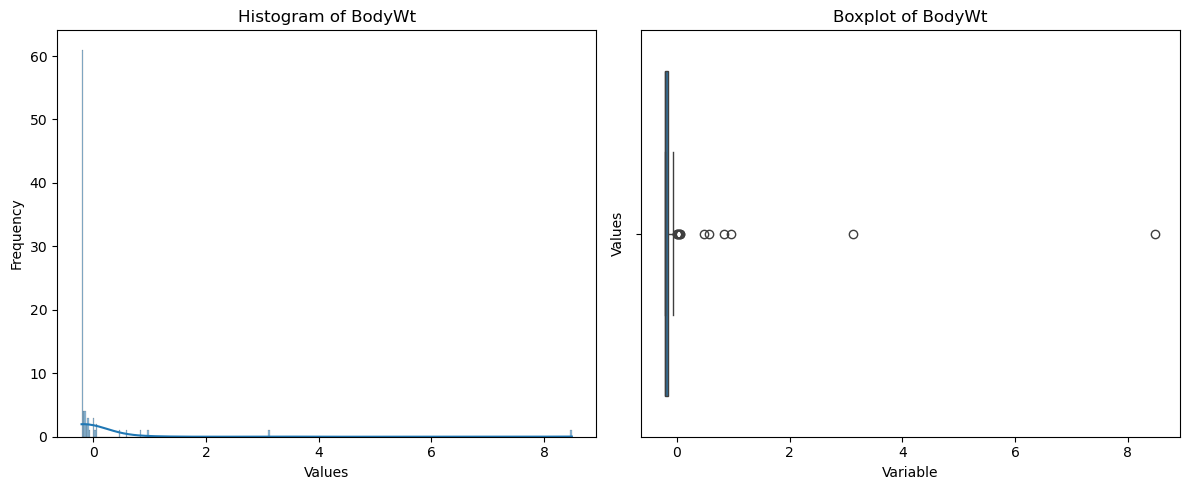

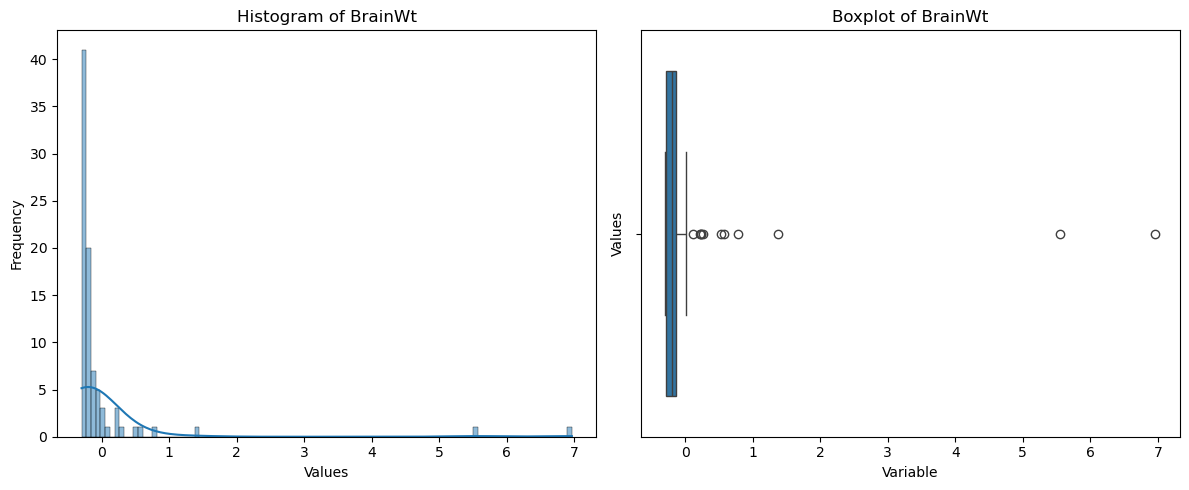

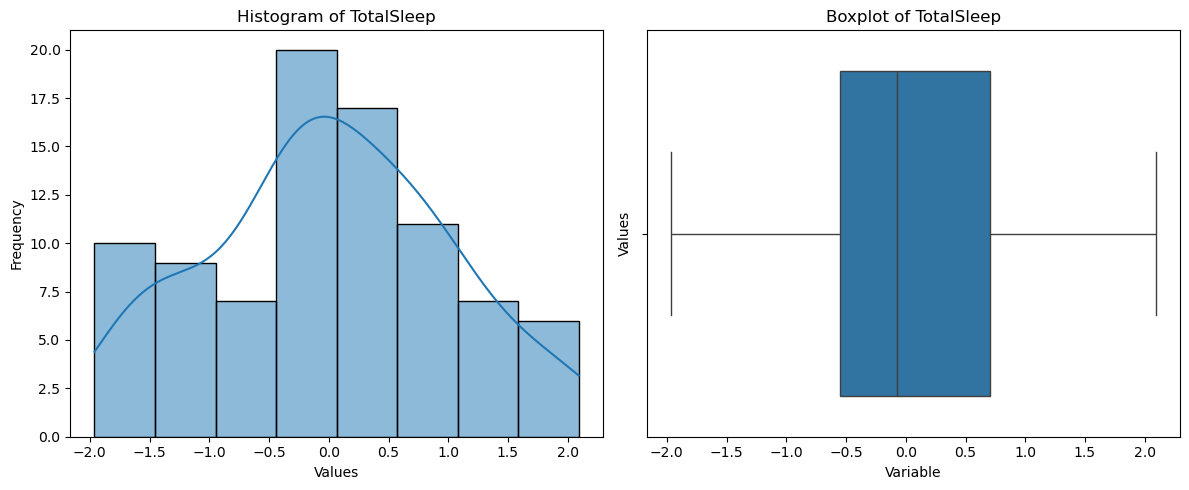

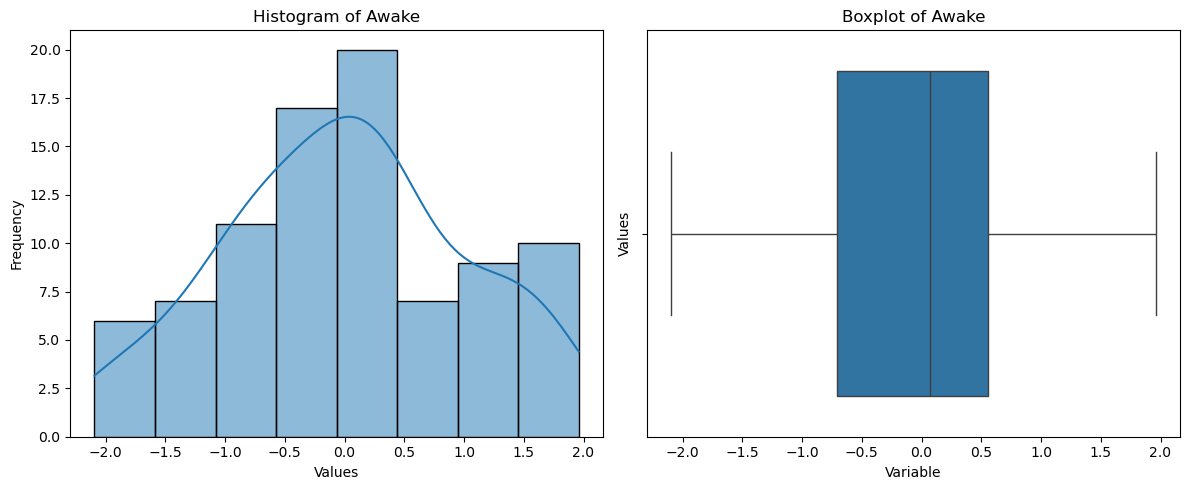

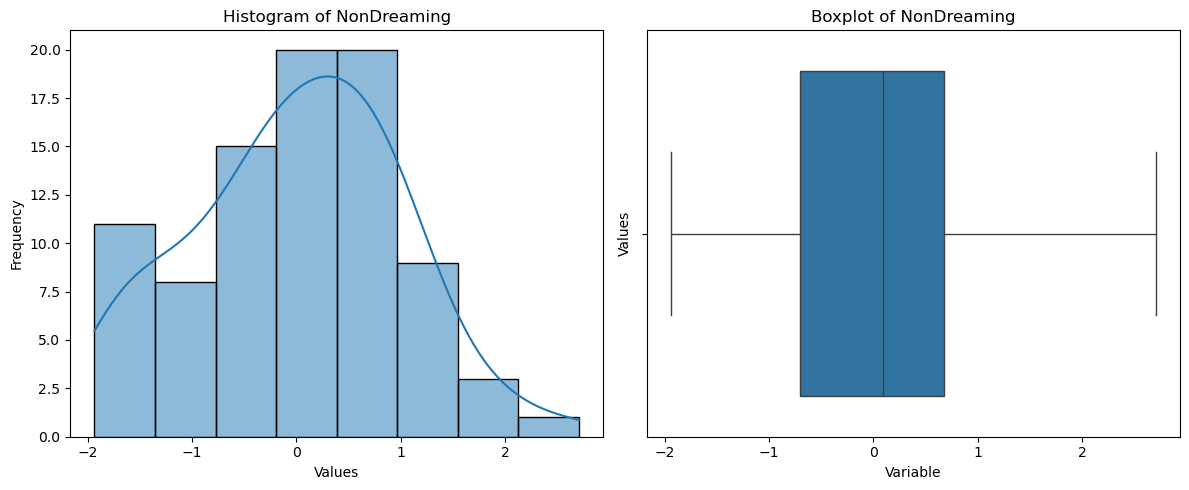

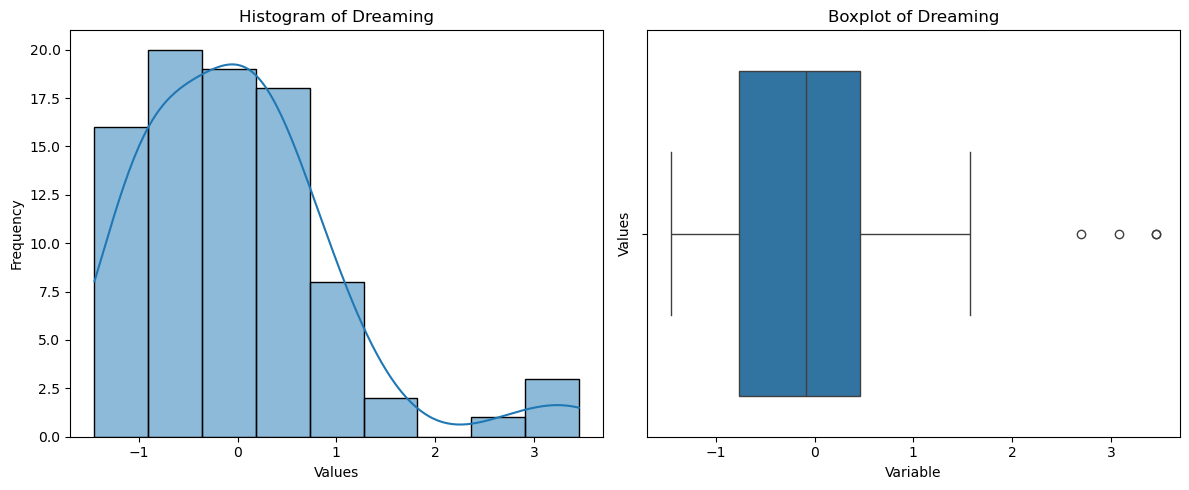

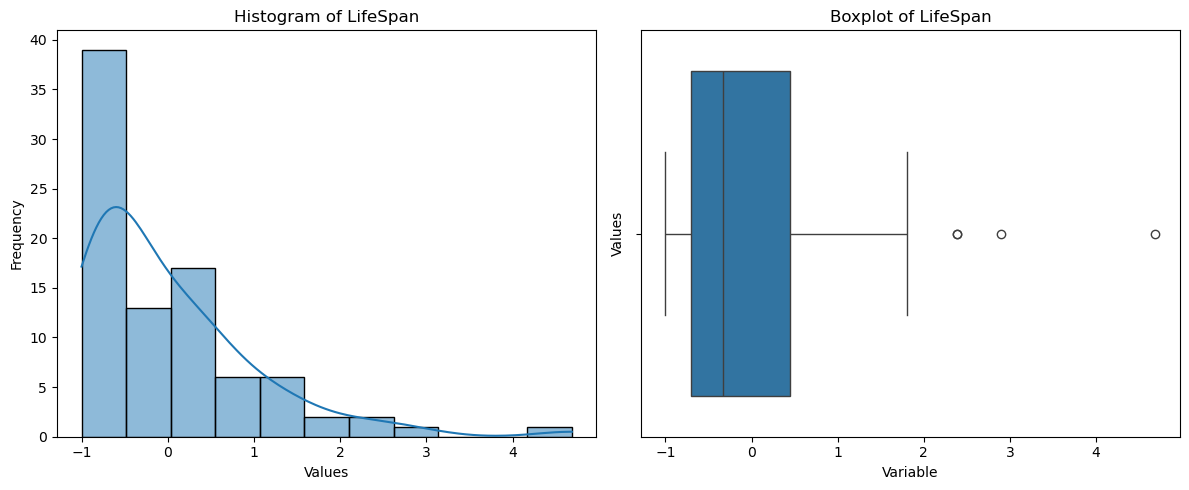

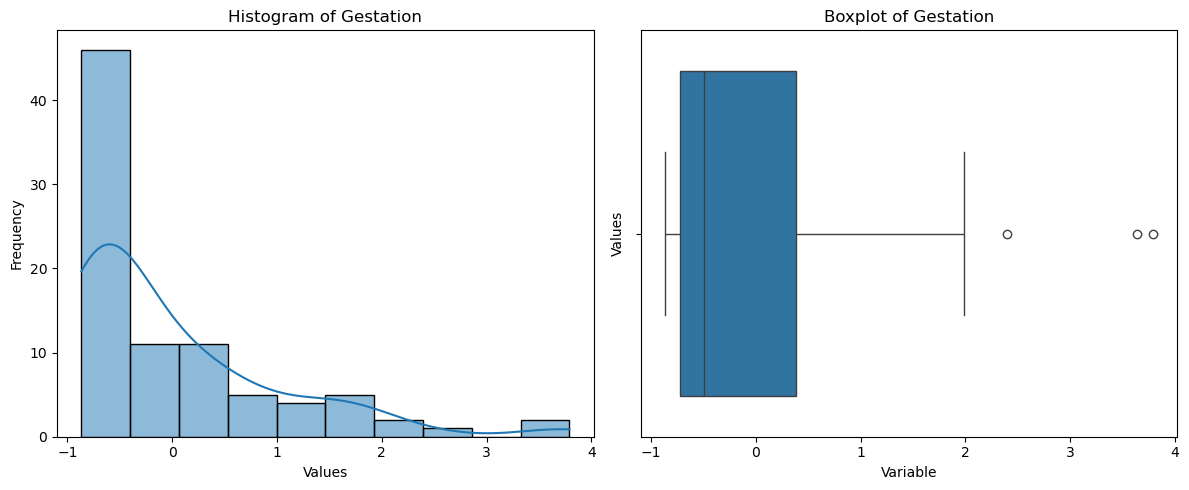

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric columns to plot
numeric_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and col not in ['Predation', 'Exposure', 'Danger']]

# Loop through the numeric columns and create separate figures for each histogram and boxplot
for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with two columns

    # Plot the histogram on the left (first subplot)
    sns.histplot(data=df, x=col, bins="auto", kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram of {col}")
    axes[0].set_xlabel("Values")
    axes[0].set_ylabel("Frequency")

    # Plot the boxplot on the right (second subplot)
    sns.boxplot(data=df, x=col, ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_xlabel("Variable")
    axes[1].set_ylabel("Values")

    plt.tight_layout()
    plt.show()  


Seems like it's well standardize.

## Saving File - Data cleaned

In [168]:
df = df.sort_values(by="Species", ascending=True)
df.to_csv("data\cleaned_sleep_merged.csv", index=False)

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\moham\AppData\Local\Temp\ipykernel_32276\1826127080.py:2: SyntaxWarning: invalid escape sequence '\c'
  df.to_csv("data\cleaned_sleep_merged.csv", index=False)


#END - next part are only some tests I let here to discuss eventually

## Test area (to test some code before implementing them in the notebook above)

In [118]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler_brain = StandardScaler()
scaler_body = StandardScaler()
# Fit and transform the 'BrainWt' feature
df['BrainWt'] = scaler_brain.fit_transform(df['BrainWt'].values.reshape(-1, 1))

from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
# scaler_body = MinMaxScaler()

# Fit and transform the 'BodyWt' feature
df['BodyWt'] = scaler_body.fit_transform(df['BodyWt'].values.reshape(-1, 1))


(array([12., 12., 16.,  9.,  4.,  5.,  1.,  0.,  1.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

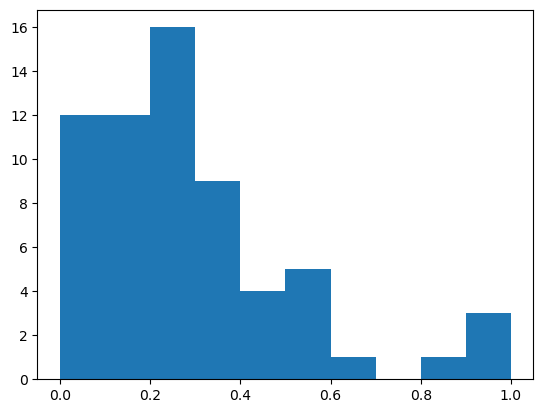

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalizer = MinMaxScaler()
df["Dreaming"] = scaler.fit_transform(df["Dreaming"].values.reshape(-1,1))
df["Dreaming"] = normalizer.fit_transform(df["Dreaming"].values.reshape(-1,1))

plt.hist(df["Dreaming"])

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Reshape the data for scaling
df['Dreaming'] = scaler.fit_transform(df['Dreaming'].values.reshape(-1, 1))

# Check the maximum value after normalization
max_normalized_value = df['Dreaming'].max()
print(max_normalized_value)  # This should be close to 1


1.0


(array([12., 12., 16.,  9.,  4.,  5.,  1.,  0.,  1.,  3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

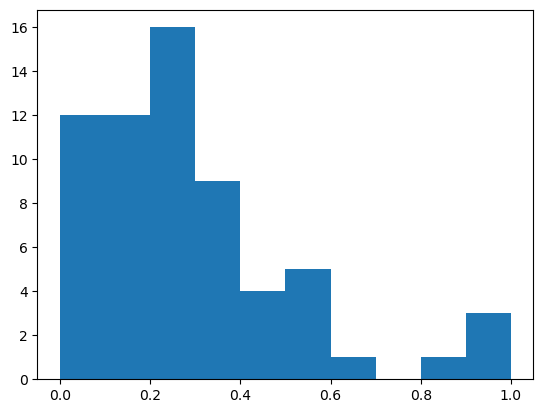

In [123]:

''' ------------------------------------------ '''

df_model_complete = df[-df["BrainWt"].isnull()]

feature = df_model_complete["BodyWt"].values.reshape(-1,1)
target = df_model_complete["BrainWt"].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size = 0.2, random_state = 10)

model = LinearRegression()
# model = GradientBoostingRegressor(random_state=10)
# model = RandomForestRegressor(random_state=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = np.maximum(y_pred,0)
y_pred = np.round(y_pred,2)

mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
print(mse, r2)

0.06769928043991173 -5.575860757815219


In [116]:
df = copy.deepcopy(data)

In [117]:
df["BrainWt"] = df["BrainWt"].replace(0, np.nan)

In [ ]:
models = {"Gradient Boosting": GradientBoostingRegressor(random_state=n),
          "KNN Regressor": KNeighborsRegressor(),
          "Random Forest": RandomForestRegressor(random_state=n),
          "Linear Regression": LinearRegression(),
          "Support Vector Machine": SVR()}

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

df_model = df[-df["Dreaming"].isnull()]
df_model_feat = df_model[["TotalSleep","Gestation","Danger"]]
df_model_targ = df_model[["Dreaming"]]

# n=int(input("Please enter an integer"))
n = 3

X_trains, X_tests, y_trains, y_tests = train_test_split(df_model_feat, df_model_targ, test_size=0.2, random_state=n)

X_trains = X_trains.values.reshape(-1,1)
y_trains = y_trains.values.reshape
X_tests = X_tests.values.reshape(-1,1)
y_tests = y_tests.values.reshape

models = {"Gradient Boosting": GradientBoostingRegressor(random_state=n),
          "KNN Regressor": KNeighborsRegressor(),
          "Random Forest": RandomForestRegressor(random_state=n),
          "Linear Regression": LinearRegression(),
          "Support Vector Machine": SVR()}

In [ ]:
def train_model(X_train, X_test, y_train, y_test):
    model_results = {}
    r2_list = {}
    residuals = []
    for name, model in models.items():  # Changed 'models' to 'model' inside the loop
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        #Storing residuals
        residual = y_test - y_pred
        #Storing results
        model_results[name] = {"MSE": mse, "R2": r2}
        best_model_name = max(model_results, key=lambda k: model_results[k]["R2"])

        #Ploting residual histograms
        plt.hist(residual, bins='auto')
        plt.title(model)
        plt.xlabel(f"Histogram for {model}")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
    
    #end of loop, printing final results
    print(f"The best model for this run was: {best_model_name}","\n\n\n")


    #create a residual dataframe
    print(residuals)
    
    return model_results